In [ ]:
pip install contractions

     |████████████████████████████████| 327kB 2.8MB/s 
     |████████████████████████████████| 286kB 7.3MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85400 sha256=ecfe40d8259277c68c5050722a108682c90241510f1522c9a872a38e153a6383
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import re
import nltk
from contractions import contractions_dict
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS
from itertools import filterfalse
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score
import time
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
data = pd.read_csv("/gdrive/MyDrive/Colab Notebooks/Email processing/emails.csv")

In [ ]:
def pre_processing(text):
    regex = r'^@[a-zA-z0-9]|^#[a-zA-Z0-9]|\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*|\W+|\d+|<("[^"]*"|\'[^\']*\'|[^\'">])*>|_+|[^\u0000-\u007f]+'
    en_stop_words = list(set(stopwords.words('english')).union(set(STOP_WORDS)))

    #strip titles
    if "Subject: re :" in text:
        text = text[13:]
    elif "Subject: news :" in text:
        text = text[15:]
    else:
        text = text[8:]

    #tokenize using nltk
    text = word_tokenize(text)

    #normalize tokens
    text = [token.lower() for token in text]

    #contraction expansion
    text = [contractions_dict[token] if token in contractions_dict.keys() else token for token in text]

    #remove waste words
    l = list()
    for token in text:
      if not(re.search(regex,token)):
        l.append(token)
    text = l
    del l

    #split
    text = [re.split(regex,token)[0] for token in text]

    #remove stop words
    l = list()
    for token in text:
      if not(token in en_stop_words or re.search(r'\b\w\b|[^\u0000-\u007f]+|_+|\W+',token)):
        l.append(token)
    text = l
    del l

    #assigning pos tag to each token
    text = pos_tag(text)
    text = [(i[0],wordnet.ADJ) if i[1][0] == 'J' else (i[0],wordnet.VERB) if i[1][0] == 'V' else (i[0],wordnet.ADV) if i[1][0] == 'R' else (i[0],wordnet.NOUN) for i in text]

    #applying lemmatizer
    lemmatizer = WordNetLemmatizer()
    if len(text) > 0:
      text = ['' if token == None else lemmatizer.lemmatize(word=token[0],pos=token[1]) for token in text]

    del regex, en_stop_words, lemmatizer
    return text

In [ ]:
# data preprocessing
data['text'] = data['text'].apply(lambda x: pre_processing(x))

In [ ]:
data

,text,spam
0,"[naturally, irresistible, corporate, identity,...",1
1,"[stock, trading, gunslinger, fanny, merrill, m...",1
2,"[unbelievable, new, home, easy, im, want, home...",1
3,"[color, print, special, request, additional, i...",1
4,"[money, software, cd, software, compatibility,...",1
...,...,...
5723,"[research, development, charge, gpg, forward, ...",0
5724,"[receipt, visit, jim, thanks, invitation, visi...",0
5725,"[enron, case, study, update, wow, day, super, ...",0
5726,"[interest, david, shirley, crenshaw, assistant...",0


In [ ]:
class GaussianNB_with_text():
  def __init__(self, data, split_ratio, n_comp):

    self.preprocessed_data = data.copy()

    self.vocab = set()
    for list_of_tokens in self.preprocessed_data['text']:
      self.vocab = self.vocab.union(set(list_of_tokens))
    
    vocab_dict = dict(zip(self.vocab,list(range(0,len(self.vocab)))))

    self.preprocessed_data['text'] = self.preprocessed_data['text'].apply(lambda x: " ".join(x))

    corpus = [i for i in self.preprocessed_data['text']]

    vectorizer = TfidfVectorizer(vocabulary=vocab_dict)
    self.tf_idf_matrix = vectorizer.fit_transform(corpus).toarray()

    pca = PCA(n_components=n_comp)
    self.tf_idf_matrix_reduced = pca.fit_transform(self.tf_idf_matrix)

    self.reduced_data = pd.DataFrame(self.tf_idf_matrix_reduced)
    self.reduced_data['spam'] = self.preprocessed_data['spam']

    X_train, self.X_test, Y_train, self.Y_test = train_test_split(self.tf_idf_matrix_reduced, np.array(self.reduced_data['spam']), test_size=split_ratio[2])
    self.X_train, self.X_cv, self.Y_train, self.Y_cv = train_test_split(X_train, Y_train, test_size=(split_ratio[1]/(1-split_ratio[2])))

    del X_train, Y_train, self.preprocessed_data, split_ratio, n_comp, vocab_dict, corpus, vectorizer, pca


  def fit(self,X,Y):
    self.Gaussian_NB_obj = GaussianNB()
    self.Gaussian_NB_obj.fit(X,Y)
  
  def evaluate(self,lables):
    return self.Gaussian_NB_obj.predict(lables)

In [ ]:
best_param = {'Accuracy':0, 'n comp':0, 'Model obj': 0}
acc = []
pre = []
r = []
t = []
all_n_comp = np.arange(2,147)
for n_comp in all_n_comp:
  start = time.time()
  print(f'n comp : {n_comp}')
  obj = GaussianNB_with_text(data, (0.7,0.2,0.1), n_comp)
  obj.fit(obj.X_train,obj.Y_train)
  predicted = obj.evaluate(obj.X_cv)
  accuracy = accuracy_score(obj.Y_cv, predicted)
  recall = recall_score(obj.Y_cv, predicted)
  precision = precision_score(obj.Y_cv, predicted)
  print(f'Accuracy : {accuracy}  |  Recall : {recall}  |  Precision  :  {precision} \n\n')
  acc.append(accuracy)
  pre.append(precision)
  r.append(recall)
  
  if best_param['Accuracy'] < accuracy:
    del best_param['Model obj']
    best_param['Accuracy'] = accuracy
    best_param['n comp'] = n_comp
    best_param['Model obj'] = obj
  else:
    del obj
  
  end = time.time()
  t.append(end-start)

  del start, predicted, accuracy, precision, recall, end

n comp : 2
Accuracy : 0.9136125654450262  |  Recall : 0.954225352112676  |  Precision  :  0.7591036414565826 


n comp : 3
Accuracy : 0.9328097731239092  |  Recall : 0.977859778597786  |  Precision  :  0.7886904761904762 


n comp : 4
Accuracy : 0.9336823734729494  |  Recall : 0.9325396825396826  |  Precision  :  0.7993197278911565 


n comp : 5
Accuracy : 0.9345549738219895  |  Recall : 0.8992805755395683  |  Precision  :  0.8417508417508418 


n comp : 6
Accuracy : 0.9528795811518325  |  Recall : 0.9482758620689655  |  Precision  :  0.8757961783439491 


n comp : 7
Accuracy : 0.9031413612565445  |  Recall : 0.650375939849624  |  Precision  :  0.9057591623036649 


n comp : 8
Accuracy : 0.8917975567190227  |  Recall : 0.5590551181102362  |  Precision  :  0.922077922077922 


n comp : 9
Accuracy : 0.8952879581151832  |  Recall : 0.5985401459854015  |  Precision  :  0.9425287356321839 


n comp : 10
Accuracy : 0.8577661431064573  |  Recall : 0.44876325088339225  |  Precision  :  0.94776

# Here I trained 145 GaussianNB at different Principal Components, It Took around 70 Minutes.

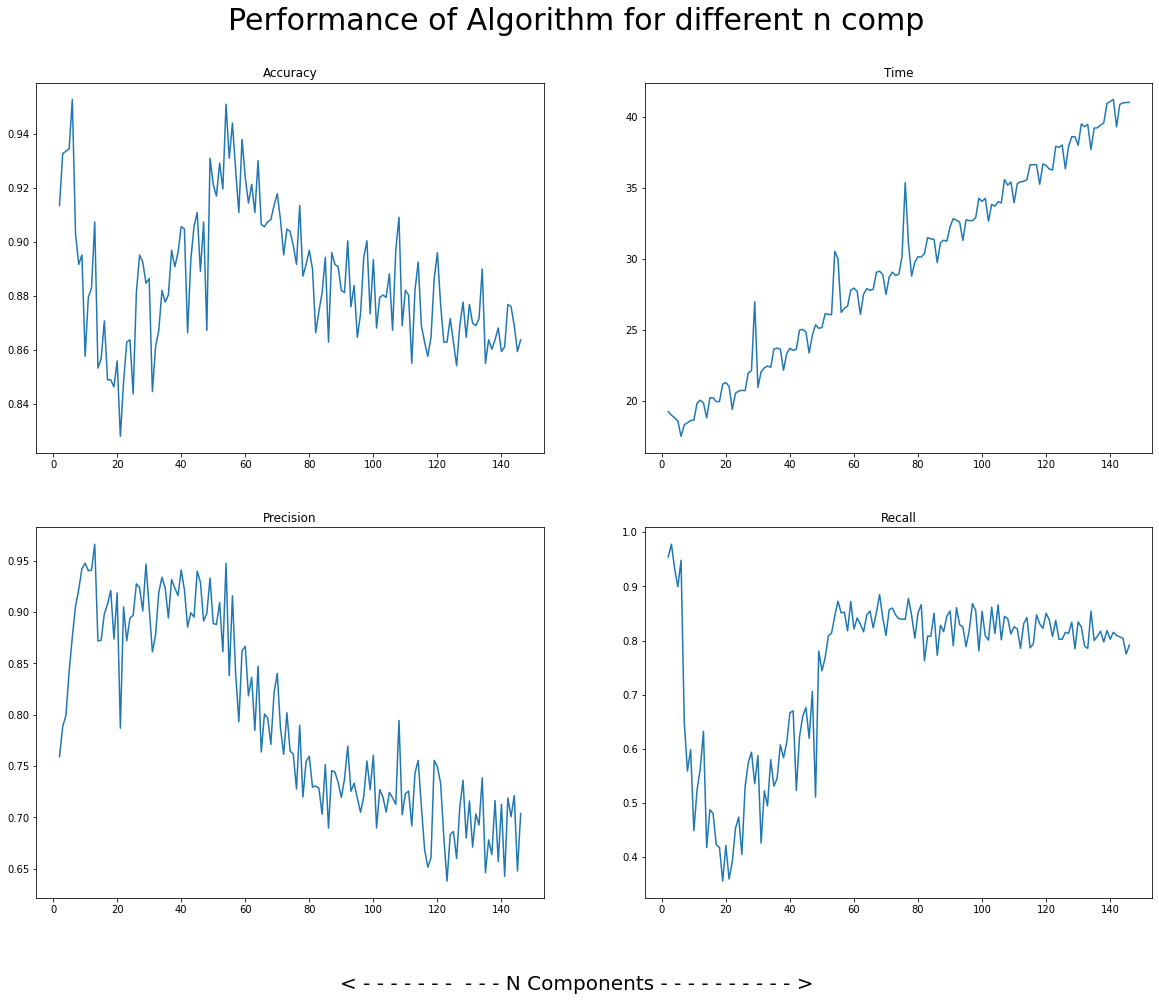

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
fig.suptitle("Performance of Algorithm for different n comp",y=0.95,fontsize=30)
axes[0][0].title.set_text('Accuracy')
axes[0][1].title.set_text('Time')
axes[1][0].title.set_text('Precision')
axes[1][1].title.set_text('Recall')

fig.text(0.5, 0.04, '< - - - - - - -  - - - N Components - - - - - - - - - - >', ha='center', fontsize=20)

axes[0][0].plot(all_n_comp,acc)
axes[0][1].plot(all_n_comp,t)
axes[1][0].plot(all_n_comp,pre)
axes[1][1].plot(all_n_comp,r)

# So here is some Performance Matrices for all trained GaussianNB.

In [ ]:
# So from the obove trained modals best modal and its Parameters are:-
best_param

{'Accuracy': 0.9528795811518325,
 'Model obj': <__main__.GaussianNB_with_text at 0x7f3e23606410>,
 'n comp': 6}

In [ ]:
best_obj = best_param['Model obj']

In [ ]:
predicted_test = best_obj.evaluate(best_obj.X_test)

In [ ]:
print(f'Accuracy : {accuracy_score(best_obj.Y_test, predicted_test)}  |  Recall : {recall_score(best_obj.Y_test, predicted_test)}  |  Precision  :  {precision_score(best_obj.Y_test, predicted_test)}')

Accuracy : 0.9616055846422339  |  Recall : 0.9637681159420289  |  Precision  :  0.8866666666666667


# So here is Modal with best parameters.